In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install clearml

In [3]:
import numpy as np
from PIL import Image, ImageDraw
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import json
from collections import defaultdict
import os
import random
import math
from tqdm import tqdm
from clearml import Task
import yaml
# import pytorch_warmup as warmup

import sys
sys.path.append('/content/drive/MyDrive/threeV_assignment/segmentation_model')
from swin_transformer import SwinUNet
from image_transforms import Compose, ReSize, RandomHorizontalFlip, RandomAffine, GaussianBlur
from livecell_dataset import LivecellDataset
from helpers import safe_collate, visualize_batch, image_resize, compute_iou, log_clearml_metrics

#some helper functions and config

In [4]:
config = {
    "version": "swin_Unet_v0.0.5",
    "training":{
        "batch_size": 32,
        "num_workers": 4,
        "num_epochs": 100,
        "loss_fn_pos_weight": 2.0,
        "learning_rate": 1e-3,
        "lr_scheduler": {
            "type": "CosineAnnealingLR",
            "tmax": 100,
            "min_lr": 1e-6
        },
        "min_epochs": 25,
        "early_stopping":5,
        "class_weigths": None,
    },
    "data":{
        "image_height": 224,
        "image_width": 224,
        "num_classes": 1,
        "transforms": {
            "flip_prob": 0.5,
            "affine_prob": 0.3,
            "blur_prob": 0.3
        }
    }
    ,
    "testing":{
        "threshold": 0.5
    }
}

#Initializing clearml settings

In [5]:
clearml_config = yaml.safe_load(open('/content/drive/MyDrive/threeV_assignment/clearml.yaml', "r"))
for key, val in clearml_config.items():
    os.environ[key] = val
task = Task.init(project_name="threeV_assignment_seg", task_name=config["version"])
task.connect(config)

ClearML Task: created new task id=9230949d481b4281afa206eb12941dc0
2024-08-26 04:19:54,391 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/b6500db0a04e4b52a9995ea694a67841/experiments/9230949d481b4281afa206eb12941dc0/output/log


/usr/local/lib/python3.10/dist-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



{'version': 'swin_Unet_v0.0.5',
 'training': {'batch_size': 32,
  'num_workers': 4,
  'num_epochs': 100,
  'loss_fn_pos_weight': 2.0,
  'learning_rate': 0.001,
  'lr_scheduler': {'type': 'CosineAnnealingLR', 'tmax': 100, 'min_lr': 1e-06},
  'min_epochs': 25,
  'early_stopping': 5,
  'class_weigths': None},
 'data': {'image_height': 224,
  'image_width': 224,
  'num_classes': 1,
  'transforms': {'flip_prob': 0.5, 'affine_prob': 0.3, 'blur_prob': 0.3}},
 'testing': {'threshold': 0.5}}

#Defining the necessary image and mask transforms

In [6]:
train_transform = Compose([
    ReSize((config["data"]["image_width"], config["data"]["image_height"])),
    RandomHorizontalFlip(config["data"]["transforms"]["flip_prob"]),
    RandomAffine(config["data"]["transforms"]["affine_prob"]),
    GaussianBlur(config["data"]["transforms"]["blur_prob"])
])

valid_transform = Compose([
    ReSize((config["data"]["image_width"], config["data"]["image_height"]))
])

In [30]:
train_dataset = LivecellDataset(
    json_file="/content/drive/MyDrive/threeV_assignment/livecell_coco_train.json",
    images_base="/content/drive/MyDrive/threeV_assignment/images/livecell_train_val_images",
    size=(config["data"]["image_width"], config["data"]["image_height"]),
    transform=train_transform
)

valid_dataset = LivecellDataset(
    json_file="/content/drive/MyDrive/threeV_assignment/livecell_coco_val.json",
    images_base="/content/drive/MyDrive/threeV_assignment/images/livecell_train_val_images",
    size=(config["data"]["image_width"], config["data"]["image_height"]),
    transform=valid_transform
)

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size = 1,
    drop_last=False,
    num_workers = config["training"]["num_workers"],
    pin_memory=True,
    collate_fn=safe_collate
)

valid_loader = DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size = 1,
    drop_last=False,
    num_workers = config["training"]["num_workers"],
    pin_memory=True,
    collate_fn=safe_collate
)

In [31]:
len(train_loader)

3188

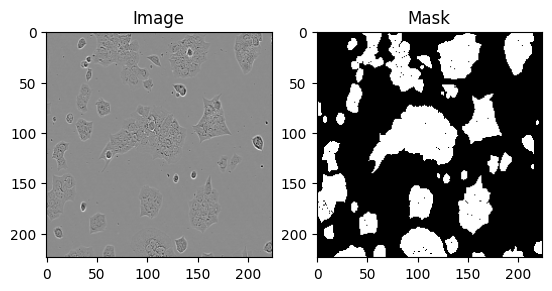

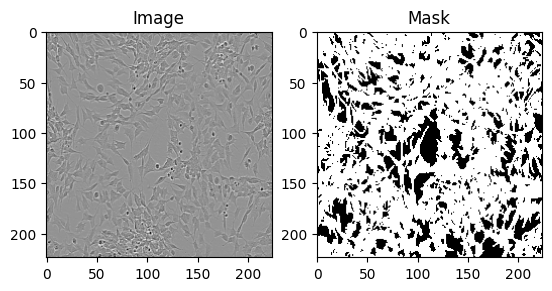

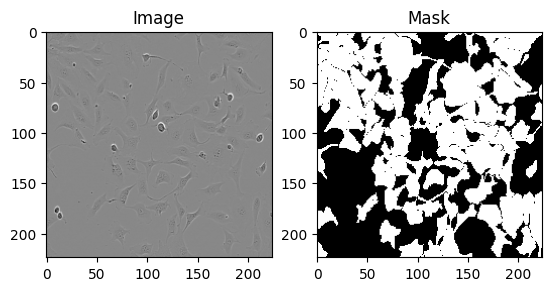

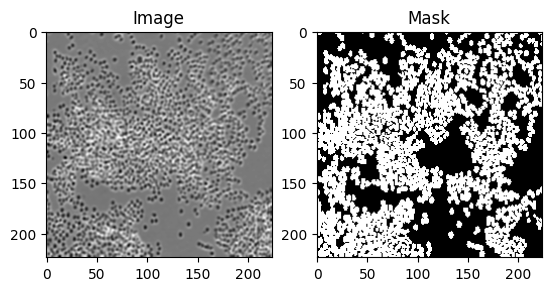

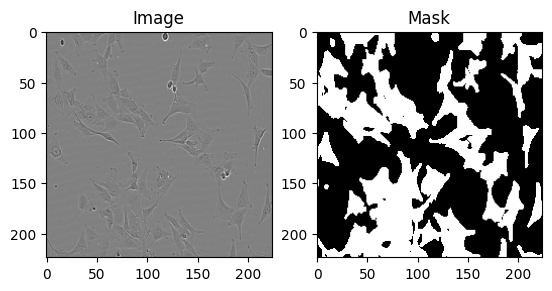

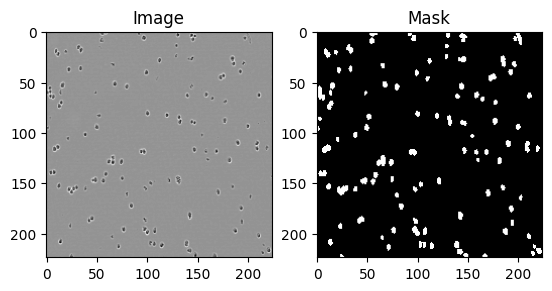

KeyboardInterrupt: 

In [28]:
# # Get a batch of data
sample = next(iter(train_loader))

# # Visualize
visualize_batch(sample)

#SWIN UNet

In [9]:
def train_epoch(model, dataloader, DEVICE, epoch):
    all_mask_gt = []
    all_mask_preds = []
    model.train()
    losses= []
    with tqdm(
        total=len(dataloader),
        desc = f"[>] Training Epoch {epoch:03d}/{config['training']['num_epochs']}"
        ) as pbar:
        for batch in dataloader:
            optimizer.zero_grad()
            batch["image"] = batch["image"].to(DEVICE)
            batch["mask"] = batch["mask"].float().to(DEVICE)
            out = model.forward(batch["image"])
            loss = loss_fn(out, batch["mask"]).to(DEVICE)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            out_mask = torch.sigmoid(out)
            out_mask = 1*(out_mask>=config["testing"]["threshold"])
            for mask_gt, mask_pred in zip(batch["mask"].cpu().int(), out_mask.cpu().int()):
                all_mask_gt.append(mask_gt[0])
                all_mask_preds.append(mask_pred[0])
            pbar.update(1)
    all_iou = []
    for mask_gt, mask_pred in zip(all_mask_gt, all_mask_preds):
        all_iou.append(compute_iou(mask_gt, mask_pred))
    return np.mean(losses), np.mean(all_iou)
def validate_epoch(model, dataloader, DEVICE, epoch):
    all_mask_gt = []
    all_mask_preds = []
    model.eval()
    losses = []
    with torch.no_grad():
        with tqdm(
            total=len(dataloader),
            desc = f"[>] Validation Epoch {epoch:03d}/{config['training']['num_epochs']}"
            ) as pbar:
            for batch in dataloader:
                batch["image"] = batch["image"].to(DEVICE)
                batch["mask"] = batch["mask"].float().to(DEVICE)
                out = model.forward(batch["image"])
                loss = loss_fn(out, batch["mask"]).to(DEVICE)
                losses.append(loss.item())
                pbar.set_postfix({"loss": loss.item()})
                out_mask = torch.sigmoid(out)
                out_mask = 1*(out_mask>=config["testing"]["threshold"])
                for mask_gt, mask_pred in zip(batch["mask"].cpu().int(), out_mask.cpu().int()):
                    all_mask_gt.append(mask_gt[0])
                    all_mask_preds.append(mask_pred[0])
                pbar.update(1)
    all_iou = []
    for mask_gt, mask_pred in zip(all_mask_gt, all_mask_preds):
        all_iou.append(compute_iou(mask_gt, mask_pred))
    return np.mean(losses), np.mean(all_iou)
def train(model, epochs, min_epochs, early_stop_count, device, clearml_task):
    best_valid_loss = float('inf')
    EARLY_STOP = early_stop_count
    for ep in range(epochs):
        epoch_metrics = {}
        current_lr = optimizer.param_groups[0]['lr']
        epoch_metrics["learning_rate"] = current_lr
        train_loss, train_iou = train_epoch(model, train_loader, device, ep)
        epoch_metrics["train_loss"] = train_loss
        epoch_metrics["train_iou_224_0.5"] = train_iou
        valid_loss, valid_iou = validate_epoch(model, valid_loader, device, ep)
        epoch_metrics["valid_loss"] = valid_loss
        epoch_metrics["valid_iou_224_0.5"] = valid_iou
        log_clearml_metrics(epoch_metrics, clearml_task, ep)
        lr_scheduler.step()
        print(f'[-] Epoch: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if ep>min_epochs:
            if(valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                EARLY_STOP = early_stop_count
            else:
                EARLY_STOP -= 1
                if EARLY_STOP <= 0:
                    return train_loss, valid_loss
    print("[>] Training Finished")
    return train_loss, valid_loss

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNet(H = config["data"]["image_height"],
                 W = config["data"]["image_width"],
                 ch = 1,
                 C = 32,
                 num_class=1,
                 num_blocks=3,
                 patch_size=4).to(device)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)

# optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])
optimizer = torch.optim.AdamW(model.parameters(), lr=config["training"]["learning_rate"])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(config["training"]["loss_fn_pos_weight"]).to(device))
# loss_fn = nn.BCEWithLogitsLoss()

if config["training"]["lr_scheduler"]["type"] == "CosineAnnealingLR":
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config["training"]["lr_scheduler"]["tmax"],
        eta_min=config["training"]["lr_scheduler"]["min_lr"])
elif config["training"]["lr_scheduler"]["type"] == "CosineAnnealingWarmRestarts":
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=config["training"]["lr_scheduler"]["t_0"],
        T_mult=config["training"]["lr_scheduler"]["t_mult"],
        eta_min=config["training"]["lr_scheduler"]["min_lr"])

train(
    model,
    epochs=config["training"]["num_epochs"],
    min_epochs=config["training"]["min_epochs"],
    early_stop_count=config["training"]["early_stopping"],
    device=device,
    clearml_task=task)

[>] Training Epoch 000/100:   0%|          | 0/100 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

[>] Training Epoch 000/100:  99%|█████████▉| 99/100 [00:21<00:00,  5.54it/s, loss=0.852]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

[>] Validation Epoch 000/100: 100%|██████████| 18/18 [00:04<00:00,  4.12it/s, loss=0.897]


[-] Epoch: 0: train_loss=0.91401, valid_loss=0.86254


[>] Validation Epoch 001/100: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s, loss=0.761]


[-] Epoch: 1: train_loss=0.71415, valid_loss=0.65065


[>] Validation Epoch 002/100: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s, loss=0.639]


[-] Epoch: 2: train_loss=0.57469, valid_loss=0.50162


[>] Validation Epoch 003/100: 100%|██████████| 18/18 [00:04<00:00,  4.27it/s, loss=0.646]


[-] Epoch: 3: train_loss=0.49408, valid_loss=0.46301


[>] Validation Epoch 004/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.597]


[-] Epoch: 4: train_loss=0.45965, valid_loss=0.43042


[>] Validation Epoch 005/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.605]


[-] Epoch: 5: train_loss=0.43334, valid_loss=0.40994


[>] Validation Epoch 006/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.596]


[-] Epoch: 6: train_loss=0.41235, valid_loss=0.39710


[>] Validation Epoch 007/100: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s, loss=0.599]


[-] Epoch: 7: train_loss=0.40328, valid_loss=0.39779


[>] Validation Epoch 008/100: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s, loss=0.569]


[-] Epoch: 8: train_loss=0.38540, valid_loss=0.36857


[>] Validation Epoch 009/100: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s, loss=0.599]


[-] Epoch: 9: train_loss=0.37407, valid_loss=0.37623


[>] Validation Epoch 010/100: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s, loss=0.559]


[-] Epoch: 10: train_loss=0.36790, valid_loss=0.36171


[>] Validation Epoch 011/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.545]


[-] Epoch: 11: train_loss=0.35911, valid_loss=0.35686


[>] Validation Epoch 012/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.541]


[-] Epoch: 12: train_loss=0.35345, valid_loss=0.33868


[>] Validation Epoch 013/100: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s, loss=0.537]


[-] Epoch: 13: train_loss=0.34422, valid_loss=0.33849


[>] Validation Epoch 014/100: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s, loss=0.528]


[-] Epoch: 14: train_loss=0.33965, valid_loss=0.32810


[>] Validation Epoch 015/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.538]


[-] Epoch: 15: train_loss=0.33414, valid_loss=0.32689


[>] Validation Epoch 016/100: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s, loss=0.553]


[-] Epoch: 16: train_loss=0.32870, valid_loss=0.32999


[>] Validation Epoch 017/100: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s, loss=0.532]


[-] Epoch: 17: train_loss=0.32759, valid_loss=0.32814


[>] Validation Epoch 018/100: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s, loss=0.514]


[-] Epoch: 18: train_loss=0.32746, valid_loss=0.31490


[>] Validation Epoch 019/100: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s, loss=0.511]


[-] Epoch: 19: train_loss=0.31896, valid_loss=0.31762


[>] Validation Epoch 020/100: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s, loss=0.504]


[-] Epoch: 20: train_loss=0.31525, valid_loss=0.30640


[>] Validation Epoch 021/100: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s, loss=0.531]


[-] Epoch: 21: train_loss=0.31558, valid_loss=0.30993


[>] Validation Epoch 022/100: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s, loss=0.498]


[-] Epoch: 22: train_loss=0.31209, valid_loss=0.30720


[>] Validation Epoch 023/100: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s, loss=0.498]


[-] Epoch: 23: train_loss=0.30827, valid_loss=0.29726


[>] Validation Epoch 024/100: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s, loss=0.494]


[-] Epoch: 24: train_loss=0.30591, valid_loss=0.29973


[>] Validation Epoch 025/100: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s, loss=0.511]


[-] Epoch: 25: train_loss=0.30814, valid_loss=0.31370


[>] Validation Epoch 026/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.52]


[-] Epoch: 26: train_loss=0.31294, valid_loss=0.31557


[>] Validation Epoch 027/100: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s, loss=0.483]


[-] Epoch: 27: train_loss=0.31701, valid_loss=0.29515


[>] Validation Epoch 028/100: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s, loss=0.483]


[-] Epoch: 28: train_loss=0.30254, valid_loss=0.29006


[>] Validation Epoch 029/100: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s, loss=0.484]


[-] Epoch: 29: train_loss=0.29863, valid_loss=0.28577


[>] Validation Epoch 030/100: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s, loss=0.478]


[-] Epoch: 30: train_loss=0.29618, valid_loss=0.28688


[>] Validation Epoch 031/100: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s, loss=0.483]


[-] Epoch: 31: train_loss=0.29274, valid_loss=0.28337


[>] Validation Epoch 032/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.473]


[-] Epoch: 32: train_loss=0.29306, valid_loss=0.28409


[>] Validation Epoch 033/100: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s, loss=0.467]


[-] Epoch: 33: train_loss=0.29091, valid_loss=0.27752


[>] Validation Epoch 034/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.469]


[-] Epoch: 34: train_loss=0.28893, valid_loss=0.27935


[>] Validation Epoch 035/100: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s, loss=0.47]


[-] Epoch: 35: train_loss=0.28605, valid_loss=0.28478


[>] Validation Epoch 036/100: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s, loss=0.474]


[-] Epoch: 36: train_loss=0.28548, valid_loss=0.28344


[>] Validation Epoch 037/100: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s, loss=0.466]


[-] Epoch: 37: train_loss=0.28504, valid_loss=0.27827


[>] Validation Epoch 038/100: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s, loss=0.465]


[-] Epoch: 38: train_loss=0.28192, valid_loss=0.27673


[>] Validation Epoch 039/100: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s, loss=0.46]


[-] Epoch: 39: train_loss=0.28207, valid_loss=0.27250


[>] Validation Epoch 040/100: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s, loss=0.461]


[-] Epoch: 40: train_loss=0.28150, valid_loss=0.27124


[>] Validation Epoch 041/100: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s, loss=0.458]


[-] Epoch: 41: train_loss=0.27840, valid_loss=0.27549


[>] Validation Epoch 042/100: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s, loss=0.46]


[-] Epoch: 42: train_loss=0.27901, valid_loss=0.27330


[>] Validation Epoch 043/100: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s, loss=0.452]


[-] Epoch: 43: train_loss=0.27720, valid_loss=0.26863


[>] Validation Epoch 044/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.456]


[-] Epoch: 44: train_loss=0.27468, valid_loss=0.26797


[>] Validation Epoch 045/100: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s, loss=0.461]


[-] Epoch: 45: train_loss=0.27857, valid_loss=0.27398


[>] Validation Epoch 046/100: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s, loss=0.453]


[-] Epoch: 46: train_loss=0.27682, valid_loss=0.26859


[>] Validation Epoch 047/100: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s, loss=0.454]


[-] Epoch: 47: train_loss=0.27370, valid_loss=0.26387


[>] Validation Epoch 048/100: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s, loss=0.448]


[-] Epoch: 48: train_loss=0.27229, valid_loss=0.26226


[>] Validation Epoch 049/100: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s, loss=0.448]


[-] Epoch: 49: train_loss=0.27068, valid_loss=0.26440


[>] Validation Epoch 050/100: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s, loss=0.449]


[-] Epoch: 50: train_loss=0.27289, valid_loss=0.26343


[>] Validation Epoch 051/100: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s, loss=0.451]


[-] Epoch: 51: train_loss=0.27294, valid_loss=0.26656


[>] Validation Epoch 052/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.446]


[-] Epoch: 52: train_loss=0.26940, valid_loss=0.25936


[>] Validation Epoch 053/100: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s, loss=0.444]


[-] Epoch: 53: train_loss=0.26799, valid_loss=0.26060


[>] Validation Epoch 054/100: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s, loss=0.45]


[-] Epoch: 54: train_loss=0.26725, valid_loss=0.26162


[>] Validation Epoch 055/100: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s, loss=0.448]


[-] Epoch: 55: train_loss=0.26650, valid_loss=0.26210


[>] Validation Epoch 056/100: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s, loss=0.45]


[-] Epoch: 56: train_loss=0.26585, valid_loss=0.26281


[>] Validation Epoch 057/100: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s, loss=0.441]


[-] Epoch: 57: train_loss=0.26587, valid_loss=0.25760


[>] Validation Epoch 058/100: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s, loss=0.443]


[-] Epoch: 58: train_loss=0.26396, valid_loss=0.25915


[>] Validation Epoch 059/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.442]


[-] Epoch: 59: train_loss=0.26490, valid_loss=0.25691


[>] Validation Epoch 060/100: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s, loss=0.443]


[-] Epoch: 60: train_loss=0.26341, valid_loss=0.25650


[>] Validation Epoch 061/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.441]


[-] Epoch: 61: train_loss=0.26330, valid_loss=0.25659


[>] Validation Epoch 062/100: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s, loss=0.44]


[-] Epoch: 62: train_loss=0.26179, valid_loss=0.25514


[>] Validation Epoch 063/100: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s, loss=0.44]


[-] Epoch: 63: train_loss=0.26178, valid_loss=0.25472


[>] Validation Epoch 064/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.441]


[-] Epoch: 64: train_loss=0.25996, valid_loss=0.25513


[>] Validation Epoch 065/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.439]


[-] Epoch: 65: train_loss=0.25999, valid_loss=0.25629


[>] Validation Epoch 066/100: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s, loss=0.436]


[-] Epoch: 66: train_loss=0.26033, valid_loss=0.25104


[>] Validation Epoch 067/100: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s, loss=0.443]


[-] Epoch: 67: train_loss=0.25821, valid_loss=0.25837


[>] Validation Epoch 068/100: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=0.437]


[-] Epoch: 68: train_loss=0.25945, valid_loss=0.25066


[>] Validation Epoch 069/100: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s, loss=0.436]


[-] Epoch: 69: train_loss=0.25984, valid_loss=0.25388


[>] Validation Epoch 070/100: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s, loss=0.435]


[-] Epoch: 70: train_loss=0.25815, valid_loss=0.25235


[>] Validation Epoch 071/100: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s, loss=0.439]


[-] Epoch: 71: train_loss=0.25788, valid_loss=0.25449


[>] Validation Epoch 072/100: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s, loss=0.438]


[-] Epoch: 72: train_loss=0.25698, valid_loss=0.25232


[>] Validation Epoch 073/100: 100%|██████████| 18/18 [00:04<00:00,  4.12it/s, loss=0.436]


[-] Epoch: 73: train_loss=0.25674, valid_loss=0.25376


(0.256743154078722, 0.25376396709018284)

In [11]:
test_dataset = LivecellDataset(
    json_file="/content/drive/MyDrive/threeV_assignment/livecell_coco_test.json",
    images_base="/content/drive/MyDrive/threeV_assignment/images/livecell_test_images",
    size=(config["data"]["image_width"], config["data"]["image_height"]),
    transform=valid_transform
)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size = 8,
    drop_last=False,
    num_workers = 4,
    pin_memory=True,
    collate_fn=safe_collate
)

In [14]:
# from ast import mod
model.eval()
losses = []
mask_predictions = {}
mask_gths = {}
# from simple_cocotools import CocoEvaluator
# evaluator = CocoEvaluator()

with torch.no_grad():
    with tqdm(
        total=len(test_loader),
        desc = f"[>]Testing images"
        ) as pbar:
        for batch in test_loader:
            batch["mask"] = batch["mask"].float()
            out = model.forward(batch["image"].to(device))
            out = out.cpu()
            loss = loss_fn(out.to(device), batch["mask"].to(device))
            out_mask = torch.sigmoid(out)
            for image_name, mask_pred, mask_gt in zip(batch["file_name"], out_mask, batch["mask"]):
                mask_predictions[image_name] = mask_pred
                mask_gths[image_name] = mask_gt
            out_mask = 1*(out_mask>=config["testing"]["threshold"])
            batch["pred"]=out_mask
            # visualize_batch(batch)
            losses.append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)
print(np.mean(losses))

[>]Testing images:   0%|          | 0/189 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

[>]Testing images: 100%|██████████| 189/189 [05:20<00:00,  1.84s/it, loss=0.451]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

[>]Testing images: 100%|██████████| 189/189 [05:20<00:00,  1.70s/it, loss=0.451]

0.24526787237830894


#Computing IOU metric for test images

In [ ]:
resized_predictions = {}
for name, mask in mask_predictions.items():
    mask = 1*(mask>=config["testing"]["threshold"]).float()
    resized_predictions[name] = image_resize(mask.unsqueeze(0), (520, 704))[0]

test_dataset_orig = LivecellDataset(
    json_file="/content/drive/MyDrive/threeV_assignment/livecell_coco_test.json",
    images_base="/content/drive/MyDrive/threeV_assignment/images/livecell_test_images",
    size=(config["data"]["image_width"], config["data"]["image_height"]),
)

test_loader_orig = DataLoader(
    test_dataset_orig,
    shuffle=False,
    batch_size = 1,
    drop_last=False,
    num_workers = 2,
    pin_memory=True,
    collate_fn=safe_collate
)
all_iou = []
with torch.no_grad():
    with tqdm(
        total=len(test_loader_orig),
        desc = f"[>]Testing images"
        ) as pbar:
        for batch in test_loader_orig:
            image = batch["image"][0]*255
            mask_gt = batch["mask"][0][0]
            mask_pred = resized_predictions[batch["file_name"][0]][0]
            visualize_batch({"image": image, "mask": mask_gt.unsqueeze(0), "pred": mask_pred.unsqueeze(0)})
            iou = compute_iou(mask_gt.int(), mask_pred.int())
            pbar.set_postfix({"iou": iou})
            all_iou.append(iou)
            pbar.update(1)
print("\n IoU of this run:", np.mean(all_iou))

In [ ]:
ckpt_path = f"/content/drive/MyDrive/threeV_assignment/trained_weights/{config['version']}.pth"
total_params = 0
for key, tensor in model.state_dict().items():
    # Calculate the number of parameters in this tensor
    num_params = tensor.numel()
    total_params += num_params
ckpt = {
    "state_dict": model.state_dict(),
    "config": config,
    "total_params": total_params,
    "test_iou": np.mean(all_iou)
}
torch.save(ckpt, ckpt_path)

In [21]:
example_gt = mask_gths["SkBr3_Phase_G3_2_03d04h00m_3.tif"].cpu()
example_pred = 1.0*(mask_predictions["SkBr3_Phase_G3_2_03d04h00m_3.tif"]>=0.5).cpu()

Text(0.5, 1.0, 'Prediction')

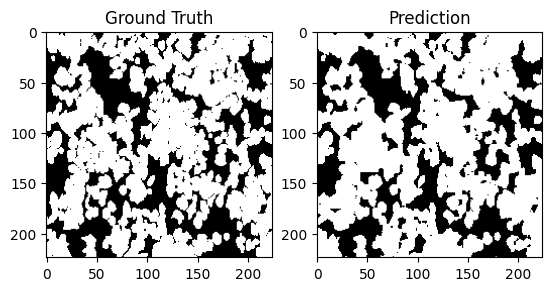

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].imshow(example_gt[0],cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(example_pred[0],cmap='gray')
ax[1].set_title('Prediction')

In [ ]:
resized_gt = image_resize(example_gt.unsqueeze(dim=0), (520, 704))
resized_prediction = image_resize(example_pred.unsqueeze(dim=0), (520, 704))
fig, ax = plt.subplots(1,2)
ax[0].imshow(resized_gt[0,0],cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(resized_prediction[0,0],cmap='gray')
ax[1].set_title('Prediction')
#